(104, (104, 136, 110), (104, 136, 110))


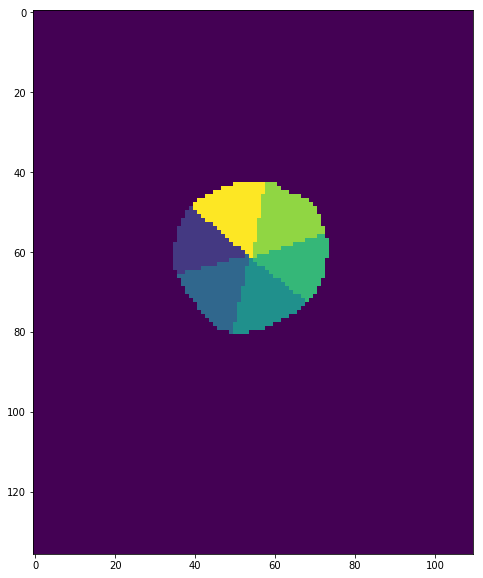

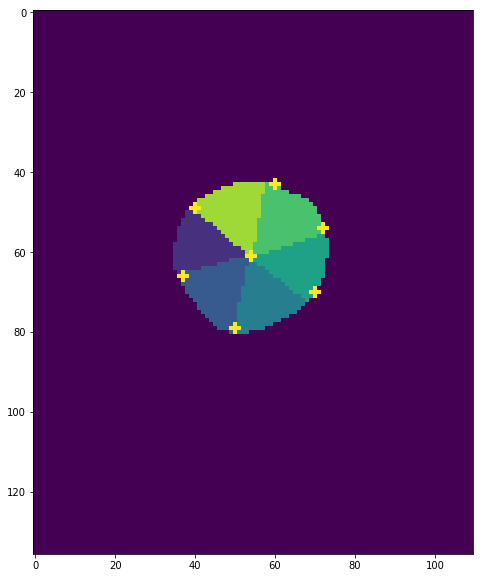

(<matplotlib.image.AxesImage at 0x7ff9ca10efd0>, None)

In [1]:
%matplotlib inline

import dicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob

dsb_path = "/home/anon/kaggle_dsb/1/study/"
label_path = "/home/anon/regional_label_np/train/1/study/"
subdirs = glob(label_path + '/*/')
labels = []
images = []

side_crop = 60

for subdir in subdirs:
    images_path = glob(subdir + '/*.npy')
    for image_path in images_path:
        dicom_end_path = image_path[image_path.rfind('/study/') + len('/study/'):image_path.rfind('.npy')]
        dc = dicom.read_file(dsb_path + dicom_end_path + '.dcm')
        image = dc.pixel_array
        image = image[side_crop:image.shape[0] - side_crop, side_crop:image.shape[1] - side_crop]
        images.append(image)
#         img=mpimg.imread(image_path)
#         img = img.copy()
        img = np.load(image_path)
        img = img[side_crop:img.shape[0] - side_crop, side_crop:img.shape[1] - side_crop]
        img[img < 20] = 0
        img[(img >= 20) & (img < 40)] = 1
        img[(img >= 40) & (img < 60)] = 2
        img[(img >= 60) & (img < 80)] = 3
        img[(img >= 80) & (img < 100)] = 4
        img[(img >= 100) & (img < 120)] = 5
        img[img >= 120] = 6
        
        labels.append(img)

# for i in range(50):
#     fig, ax = plt.subplots(figsize=(8, 6))
#     plt.imshow(images[i])
#     plt.show()
#     fig, ax = plt.subplots(figsize=(8, 6))
#     plt.imshow(labels[i])
#     plt.show()

# print(len(images))
# print(len(labels))

# np.set_printoptions(threshold=np.nan)
# print(labels[0][120:140, 100:130])

# fig, ax = plt.subplots(figsize=(10, 8))
# plt.imshow(labels[100])
# print(labels[100][40:80, 55:70])

X = np.rollaxis(np.dstack(images), -1)
Y = np.rollaxis(np.dstack(labels), -1)
# print(X.shape, Y.shape)

##########################################################
##########################################################
##########################################################
##########################################################
##########################################################

import cv2

# img = Y[100]
# fig, ax = plt.subplots(figsize=(12, 10))
# plt.imshow(img)

fav_X = np.zeros((104, X.shape[1], X.shape[2]))
fav_Y = np.zeros((104, Y.shape[1], Y.shape[2]), dtype=np.int32)
fav_corners = np.zeros((104, 7, 2), dtype=np.int0) # 7 corners for each fav image
# dst = cv2.cornerHarris(Y[100],2,3,0.04)
# fig, ax = plt.subplots(figsize=(12, 10))
# plt.imshow(dst)
counter = 0
index = 0
for i in range(Y.shape[0]):
    corners = cv2.goodFeaturesToTrack(Y[i],7,0.01,14)
    corners = np.int0(corners)
    if corners.shape[0] == 7:
        fav_X[index] = X[i]
        fav_Y[index] = Y[i]
        fav_corners[index] = corners.reshape((7, 2))
        index += 1
        counter += 1
        
print(counter, fav_X.shape, fav_Y.shape)


z = fav_Y[60].copy()
fig, ax = plt.subplots(figsize=(12, 10))
plt.imshow(z)

for i in fav_corners[60]:
    x,y = i.ravel()
#     print(x, y)
    cv2.circle(z,(x,y),1,7,-1)

fig, ax = plt.subplots(figsize=(12, 10))
plt.imshow(z),plt.show()

In [ ]:
batch_size = 16
num_out = 14 # 7 corners
smooth_factor = 1.0

# input image dimensions
img_rows, img_cols = fav_X.shape[1], fav_X.shape[2]

# the data, shuffled and split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

from sklearn.utils import shuffle
fav_X, fav_Y, fav_corners = shuffle(fav_X, fav_Y, fav_corners, random_state=0)

x_train = fav_X[:80]
x_test = fav_X[80:]
y_train = fav_corners[:80]
y_test = fav_corners[80:]

y_train_seg = fav_Y[:80]
y_test_seg = fav_Y[80:]

y_train = y_train.reshape((y_train.shape[0], 14))
y_test = y_test.reshape((y_test.shape[0], 14))

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


def dice_coef(y_true, y_pred):
    print(y_true)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth_factor) / \
           (K.sum(y_true_f) + K.sum(y_pred_f) + smooth_factor)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)



def get_model():
    drop_rate_concat = 0.4
    drop_rate_hidden = 0.4
    bn_momentum = 0.1
    
    inputs = Input((CROP_HEIGHT, CROP_WIDTH, 1))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=bn_momentum)(conv1)
    conv1 = Dropout(drop_rate_hidden)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=bn_momentum)(conv1)
    conv1 = Dropout(drop_rate_hidden)(conv1)
    
    # Rate 2
    conv3 = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu',
                   padding='same', name="rate2_1")(conv1)
    conv3 = BatchNormalization(momentum=bn_momentum)(conv3)
    conv3 = Dropout(drop_rate_hidden)(conv3)
    conv3 = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu',
                   padding='same', name="rate2_2")(conv3)
    conv3 = BatchNormalization(momentum=bn_momentum)(conv3)
    conv3 = Dropout(drop_rate_hidden)(conv3)
    
    ############ Branches for ASPP
    
    # Branch for 1x1
    conv3a = Conv2D(32, (3, 3), activation='relu',
                    padding='same', name="branch1x1_1")(conv3)
    conv3a = BatchNormalization(momentum=bn_momentum)(conv3a)
    conv3a = Dropout(drop_rate_hidden)(conv3a)
    conv3a = Conv2D(32, (1, 1), activation='relu',
                    padding='same', name="branch1x1_2")(conv3a)
    conv3a = BatchNormalization(momentum=bn_momentum)(conv3a)
    conv3a = Dropout(drop_rate_hidden)(conv3a)
    
    # Branch for 3x3 rate 6
    conv4 = Conv2D(32, (3, 3), dilation_rate=(6, 6), activation='relu',
                   padding='same', name="rate6_1")(conv3)
    conv4 = BatchNormalization(momentum=bn_momentum)(conv4)
    conv4 = Dropout(drop_rate_hidden)(conv4)
    conv4 = Conv2D(32, (3, 3), dilation_rate=(6, 6), activation='relu',
                   padding='same', name="rate6_2")(conv4)
    conv4 = BatchNormalization(momentum=bn_momentum)(conv4)
    conv4 = Dropout(drop_rate_hidden)(conv4)
    
    # Branch for 3x3 rate 12
    conv5 = Conv2D(32, (3, 3), dilation_rate=(12, 12), activation='relu',
                   padding='same', name="rate12_1")(conv3)
    conv5 = BatchNormalization(momentum=bn_momentum)(conv5)
    conv5 = Dropout(drop_rate_hidden)(conv5)
    conv5 = Conv2D(32, (3, 3), dilation_rate=(12, 12), activation='relu',
                   padding='same', name="rate12_2")(conv5)
    conv5 = BatchNormalization(momentum=bn_momentum)(conv5)
    conv5 = Dropout(drop_rate_hidden)(conv5)
    
    # Branch for 3x3 rate 18
    conv6 = Conv2D(32, (3, 3), dilation_rate=(18, 18), activation='relu',
                   padding='same', name="rate18_1")(conv3)
    conv6 = BatchNormalization(momentum=bn_momentum)(conv6)
    conv6 = Dropout(drop_rate_hidden)(conv6)
    conv6 = Conv2D(32, (3, 3), dilation_rate=(18, 18), activation='relu',
                   padding='same', name="rate18_2")(conv6)
    conv6 = BatchNormalization(momentum=bn_momentum)(conv6)
    conv6 = Dropout(drop_rate_hidden)(conv6)
    
    # Branch for 3x3 rate 24
    conv7 = Conv2D(32, (3, 3), dilation_rate=(24, 24), activation='relu',
                   padding='same', name="rate24_1")(conv3)
    conv7 = BatchNormalization(momentum=bn_momentum)(conv7)
    conv7 = Dropout(drop_rate_hidden)(conv7)
    conv7 = Conv2D(32, (3, 3), dilation_rate=(24, 24), activation='relu',
                   padding='same', name="rate24_2")(conv7)
    conv7 = BatchNormalization(momentum=bn_momentum)(conv7)
    conv7 = Dropout(drop_rate_hidden)(conv7)
    
    # Branch for the global context
    global_pool = GlobalAveragePooling2D()(conv1)
    global_pool = RepeatVector(CROP_HEIGHT*CROP_WIDTH)(global_pool)
    global_pool = Reshape((CROP_HEIGHT, CROP_WIDTH, 32))(global_pool)
    
    ############# Concatenation 
    concat = concatenate([conv3a, conv4, conv5,
                          conv6, global_pool, conv7], axis=3)
    concat = BatchNormalization(momentum=bn_momentum)(concat)
    concat = Dropout(drop_rate_concat)(concat)
    
    amort = Conv2D(64, (1, 1), activation='relu',
                   padding='same', name="amort")(concat)
    amort = BatchNormalization(momentum=bn_momentum)(amort)
    amort = Dropout(drop_rate_hidden)(amort)

    predictions = Conv2D(num_classes, (1, 1), activation='softmax',
                         padding='same', name="predictions")(amort)
    
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_out, activation='relu'))
    model = Model(inputs=[inputs], outputs=[predictions])
    
    return model

model = get_model()

model.compile(loss='mse', optimizer='rmsprop', metrics=["mse", "mae"])

# model.compile(optimizer=keras.optimizers.Adadelta(),
#               loss=keras.losses.categorical_crossentropy,
#               metrics=["accuracy"])

model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=2, validation_data=(x_test, y_test))

In [2]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 16
num_out = 14 # 7 corners
smooth_factor = 1.0

# input image dimensions
img_rows, img_cols = fav_X.shape[1], fav_X.shape[2]

# the data, shuffled and split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

from sklearn.utils import shuffle
fav_X, fav_Y, fav_corners = shuffle(fav_X, fav_Y, fav_corners, random_state=0)

x_train = fav_X[:80]
x_test = fav_X[80:]
y_train = fav_corners[:80]
y_test = fav_corners[80:]

y_train_seg = fav_Y[:80]
y_test_seg = fav_Y[80:]

y_train = y_train.reshape((y_train.shape[0], 14))
y_test = y_test.reshape((y_test.shape[0], 14))

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


def dice_coef(y_true, y_pred):
    print(y_true)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth_factor) / \
           (K.sum(y_true_f) + K.sum(y_pred_f) + smooth_factor)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding="same",
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_out, activation='relu'))

model.compile(loss='mse', optimizer='rmsprop', metrics=["mse", "mae"])

# model.compile(optimizer=keras.optimizers.Adadelta(),
#               loss=keras.losses.categorical_crossentropy,
#               metrics=["accuracy"])

model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=2, validation_data=(x_test, y_test))

# score = model.evaluate(x_test, y_test_one_hot, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
80 train samples
24 test samples
x_train shape: (80, 136, 110, 1)
y_train shape: (80, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 136, 110, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 136, 110, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 27, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7344)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                235040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)        

(24, 14)


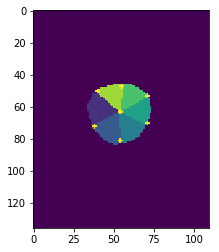

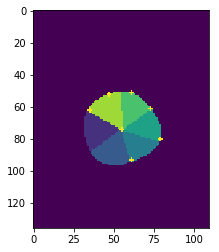

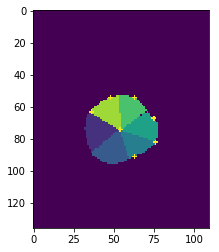

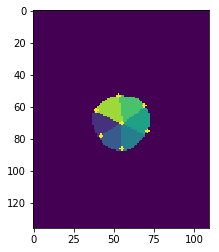

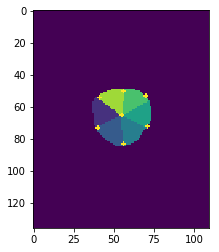

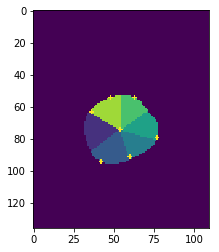

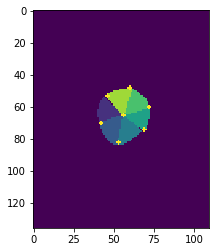

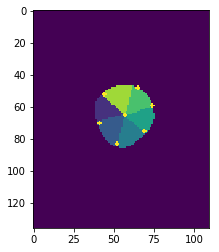

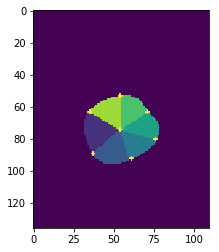

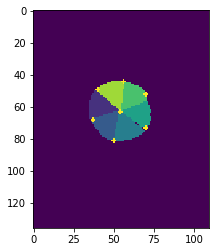

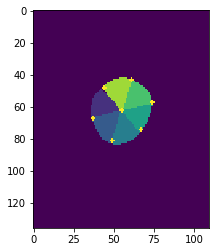

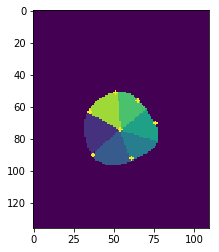

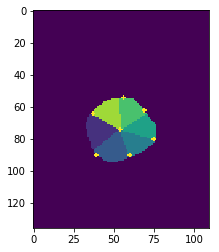

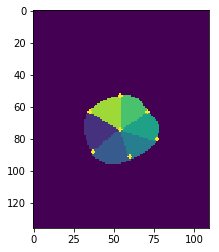

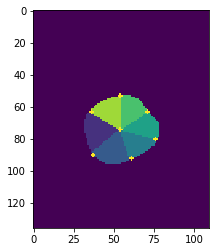

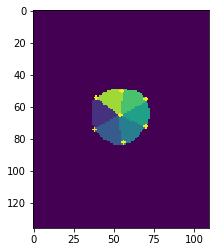

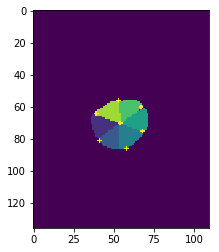

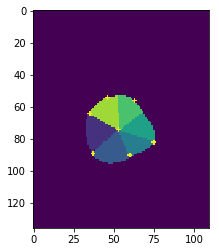

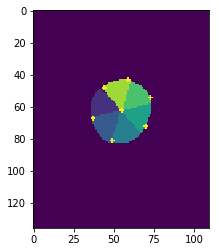

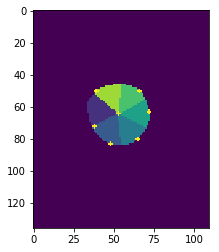

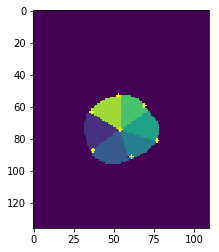

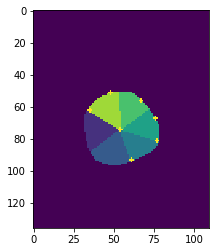

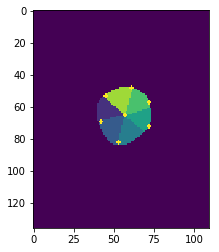

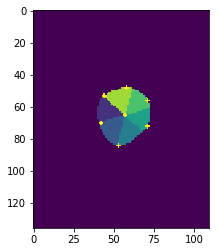

In [3]:
sample_output = model.predict_on_batch(x_test)
print(sample_output.shape)

for index in range(sample_output.shape[0]):
    z = np.copy(y_test_seg[index])
#     pred_corners = sample_output[index].reshape(7, 2)
#     for i in pred_corners:
#         x,y = i.ravel()
#         cv2.circle(z,(x,y),1,7,-1)
    actual_corners = y_test[index].reshape(7, 2)
    for i in actual_corners:
        x,y = i.ravel()
        cv2.circle(z,(x,y),1,7,-2)
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.imshow(z),plt.show()